# Docker for NMR software

This follows using the docker with NMR software at: https://github.com/tlinnet/docker_relax/blob/master/README.md

* [nmrglue examples](https://github.com/jjhelmus/nmrglue/tree/master/examples)
* [nmrglue archive](https://code.google.com/archive/p/nmrglue/downloads)

[This example](https://github.com/jjhelmus/nmrglue/tree/master/examples/jbnmr_examples/s12-s15_relaxation_analysis) is taken from Listing S12 - S15 in the 2013 JBNMR nmrglue paper. In this example a series of 3D NMRPipe files containing relaxation trajectories for a solid state NMR experment and analyzed.

**The code has here been refactored to a complete analysis in JupyterLab.**


* The data is downloaded with bash command curl
* The data is unpacked with bash command unzip
* The data is arranged into folders
* The data is analysed with [NMRPipe](https://spin.niddk.nih.gov/NMRPipe/ref/scripts/) script [peakHN.tcl](https://spin.niddk.nih.gov/NMRPipe/ref/scripts/peakhn_tcl.html)
* The spectrum is plotted in matplotlib in JupyterLab
* An analysis script for **relax** is written and executed
* All data is analysed in **relax**

# Get data
Change the comment line to **True**, to download

In [1]:
#if True:
if False:
    ! curl -O https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/nmrglue/jbnmr_s12-s15_relaxation_analysis_part1.zip
    ! curl -O https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/nmrglue/jbnmr_s12-s15_relaxation_analysis_part2.zip
    ! curl -O https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/nmrglue/jbnmr_s12-s15_relaxation_analysis_part3.zip
    ! curl -O https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/nmrglue/jbnmr_s12-s15_relaxation_analysis_part4.zip

In [2]:
# See dowloaded files and unzip directory
%ls

jbnmr_s12-s15_relaxation_analysis_part1.zip
jbnmr_s12-s15_relaxation_analysis_part2.zip
jbnmr_s12-s15_relaxation_analysis_part3.zip
jbnmr_s12-s15_relaxation_analysis_part4.zip
relaxation_analysis.ipynb


# Unpack data
Change the comment line to **True**, to unzip

In [3]:
if True:
#if False:
    ! unzip -o jbnmr_s12-s15_relaxation_analysis_part1.zip
    ! unzip -o jbnmr_s12-s15_relaxation_analysis_part2.zip
    ! unzip -o jbnmr_s12-s15_relaxation_analysis_part3.zip
    ! unzip -o jbnmr_s12-s15_relaxation_analysis_part4.zip

Archive:  jbnmr_s12-s15_relaxation_analysis_part1.zip
  inflating: s12-s15_relaxation_analysis/README.rst  
  inflating: s12-s15_relaxation_analysis/fit_exp.py  
  inflating: s12-s15_relaxation_analysis/extract_traj.py  
  inflating: s12-s15_relaxation_analysis/plot_boxes.py  
  inflating: s12-s15_relaxation_analysis/plot_trajectories.py  
  inflating: s12-s15_relaxation_analysis/spectra.in  
  inflating: s12-s15_relaxation_analysis/boxes.in  
  inflating: s12-s15_relaxation_analysis/relaxation_times.in  
  inflating: s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2  
  inflating: s12-s15_relaxation_analysis/data/Ytau_100000.fid/test.ft2  
  inflating: s12-s15_relaxation_analysis/data/Ytau_250000.fid/test.ft2  
Archive:  jbnmr_s12-s15_relaxation_analysis_part2.zip
  inflating: s12-s15_relaxation_analysis/data/Ytau_500000.fid/test.ft2  
  inflating: s12-s15_relaxation_analysis/data/Ytau_750000.fid/test.ft2  
  inflating: s12-s15_relaxation_analysis/data/Ytau_1000000.fid/test.ft2  

In [4]:
# See dowloaded files and unzip directory
%ls

jbnmr_s12-s15_relaxation_analysis_part1.zip
jbnmr_s12-s15_relaxation_analysis_part2.zip
jbnmr_s12-s15_relaxation_analysis_part3.zip
jbnmr_s12-s15_relaxation_analysis_part4.zip
relaxation_analysis.ipynb
s12-s15_relaxation_analysis/


In [5]:
# See dowloaded files in the unzip directory
%ls -la s12-s15_relaxation_analysis

total 32
drwxr-xr-x 11 developer developer  374 Oct 30 08:57 ./
drwxr-xr-x  9 developer developer  306 Oct 30 08:57 ../
-rw-r--r--  1 developer developer 1350 Mar  3  2013 README.rst
-rw-r--r--  1 developer developer  847 Mar  3  2013 boxes.in
drwxr-xr-x 12 developer developer  408 Oct 30 08:56 data/
-rw-r--r--  1 developer developer 1126 Mar  3  2013 extract_traj.py
-rw-r--r--  1 developer developer 1164 Mar  3  2013 fit_exp.py
-rw-r--r--  1 developer developer 1851 Mar  3  2013 plot_boxes.py
-rw-r--r--  1 developer developer  936 Mar  3  2013 plot_trajectories.py
-rw-r--r--  1 developer developer   85 Mar  3  2013 relaxation_times.in
-rw-r--r--  1 developer developer  302 Mar  3  2013 spectra.in


In [15]:
# Have a look at the data folder
%ls -vd1 s12-s15_relaxation_analysis/data/*

s12-s15_relaxation_analysis/data/Ytau_100.fid/
s12-s15_relaxation_analysis/data/Ytau_100000.fid/
s12-s15_relaxation_analysis/data/Ytau_250000.fid/
s12-s15_relaxation_analysis/data/Ytau_500000.fid/
s12-s15_relaxation_analysis/data/Ytau_750000.fid/
s12-s15_relaxation_analysis/data/Ytau_1000000.fid/
s12-s15_relaxation_analysis/data/Ytau_1500000.fid/
s12-s15_relaxation_analysis/data/Ytau_2000000.fid/
s12-s15_relaxation_analysis/data/Ytau_3000000.fid/
s12-s15_relaxation_analysis/data/Ytau_4000000.fid/


In [16]:
# Get order of data. 
# https://www.safaribooksonline.com/blog/2014/02/12/using-shell-commands-effectively-ipython/
#%ls -v -d -1 s12-s15_relaxation_analysis/data/*/*.ft2
!ls -v -d -1 s12-s15_relaxation_analysis/data/*/*.ft2 > ft2_files.ls
!cat ft2_files.ls

s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2
s12-s15_relaxation_analysis/data/Ytau_100000.fid/test.ft2
s12-s15_relaxation_analysis/data/Ytau_250000.fid/test.ft2
s12-s15_relaxation_analysis/data/Ytau_500000.fid/test.ft2
s12-s15_relaxation_analysis/data/Ytau_750000.fid/test.ft2
s12-s15_relaxation_analysis/data/Ytau_1000000.fid/test.ft2
s12-s15_relaxation_analysis/data/Ytau_1500000.fid/test.ft2
s12-s15_relaxation_analysis/data/Ytau_2000000.fid/test.ft2
s12-s15_relaxation_analysis/data/Ytau_3000000.fid/test.ft2
s12-s15_relaxation_analysis/data/Ytau_4000000.fid/test.ft2


In [17]:
# Read into list
with open('ft2_files.ls', "r") as f:
    fid_files = f.read().splitlines()

In [18]:
# Get some info
fid_file1 = fid_files[0]
!showApod $fid_file1
!showhdr $fid_file1

REMARK Effect of Processing on Peak Parameters and Noise for s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2
REMARK Automated Noise Std Dev in Processed Data: 3556.26
REMARK Noise Std Dev Before Processing C13 and N15: 13.5848

VARS   AXIS LABEL  TSIZE FSIZE LW_ADJ LW_FINAL HI_FACTOR VOL_FACTOR SIGMA_FACTOR
FORMAT %s   %-8s   %4d   %4d   %7.4f  %7.4f    %.4e      %.4e       %.4e

       X    C13     1500  8192 1.1033 6.9883   2.4234e-03 2.4718e-04 3.3248e-02
       Y    N15      128  2048 2.9694 20.3856   2.8449e-02 9.8873e-04 1.1490e-01
FILE: s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2 DIM: 2 QUAD: Real 2DMODE: States Not Transposed
BYTES: 67110912 PRED: 67110912 MIN: 0 MAX: 0 VALID: 0
ORDER: 2 1 PIPE: 0 CUBE: 0 FILES: 1 8192x2048x1

               X-Axis        Y-Axis   

DATA SIZE:          8192         2048
APOD SIZE:          1500          128
SW Hz:      50000.000000  5000.000000
OBS MHz:      125.690002    50.647999
ORIG Hz:    -2746.765625  3681.497070
DOMAIN:

In [30]:
# Get info
!showhdr $fid_file1 | grep "OBS MHz:"
w0_15N_arr = !showhdr $fid_file1 | grep "OBS MHz:"
print(w0_15N_arr[0].split()[3])

OBS MHz:      125.690002    50.647999
50.647999


In [33]:
# Calculate the Larmor frequency for proton
# http://bio.groups.et.byu.net/LarmourFreqCal.phtml
# http://web.mit.edu/speclab/www/Facility/nmrfreq.html
w0_15N = float(w0_15N_arr[0].split()[3]) # Larmor frequency for 15N [MHz]
g_15N = 4.317267 # Gyromagnetic Ratio for 15N [MHz/T]
B0 = w0_15N / g_15N # Magnet Field Strength [T]
g_1H = 42.57748 # Gyromagnetic Ratio for 1H [MHz/T]
w0_1H = g_1H*B0 # Larmor frequency for 15N [MHz]
print("Spectrometer frequency %.3f in 1H MHz"%w0_1H)    

Spectrometer frequency 499.498 in 1H MHz


# Collect data information

In [34]:
fid_times = []
fid_rmsd = []
lines = []
print("\nPath to .ft2, time in us, rmsd noise")
for fid in fid_files:
    time = int(fid.split("Ytau_")[-1].split(".fid")[0])
    # Get output from showApod
    showApod_out = !showApod $fid | grep "REMARK Automated Noise Std Dev in Processed Data:"
    # Get noise
    rmsd = showApod_out[0].split(" ")[-1]
    # Collect
    lines.append("%s %s %s %.3f"%(fid, time, rmsd, w0_1H))
    print(lines[-1])
    fid_times.append(time)
    fid_rmsd.append(rmsd)

# Store info
with open('ft2_files_info.txt', "w") as f:
    for line in lines:
        f.write(line + "\n")


Path to .ft2, time in us, rmsd noise
s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2 100 3556.26 499.498
s12-s15_relaxation_analysis/data/Ytau_100000.fid/test.ft2 100000 3517.99 499.498
s12-s15_relaxation_analysis/data/Ytau_250000.fid/test.ft2 250000 3513.73 499.498
s12-s15_relaxation_analysis/data/Ytau_500000.fid/test.ft2 500000 3544.81 499.498
s12-s15_relaxation_analysis/data/Ytau_750000.fid/test.ft2 750000 3526.03 499.498
s12-s15_relaxation_analysis/data/Ytau_1000000.fid/test.ft2 1000000 3532.23 499.498
s12-s15_relaxation_analysis/data/Ytau_1500000.fid/test.ft2 1500000 3563.8 499.498
s12-s15_relaxation_analysis/data/Ytau_2000000.fid/test.ft2 2000000 3536.76 499.498
s12-s15_relaxation_analysis/data/Ytau_3000000.fid/test.ft2 3000000 3506.51 499.498
s12-s15_relaxation_analysis/data/Ytau_4000000.fid/test.ft2 4000000 3529.68 499.498


# Inspect collected data

In [7]:
# See file
! head -n 4 ft2_files_info.txt

s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2 100 3556.26 499.488
s12-s15_relaxation_analysis/data/Ytau_100000.fid/test.ft2 100000 3517.99 499.488
s12-s15_relaxation_analysis/data/Ytau_250000.fid/test.ft2 250000 3513.73 499.488
s12-s15_relaxation_analysis/data/Ytau_500000.fid/test.ft2 500000 3544.81 499.488


# Make an automated peak list

In [37]:
# Get a test peak list with NMRPipe
ftfile = fid_files[0]
# Auto detect peaks
! peakHN.tcl -in s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2 -out test.tab




ROI Name='s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2' Length: 16824335 Orig Dim: 2 Dim: 2

ROI X: X_AXIS 1 -> 8195 8195 Pts 1 -> 8195
 Offset: 0 Align=None(0.000,0.000) Window: None
ROI Y: Y_AXIS 1 -> 2053 2053 Pts 1 -> 2053
 Offset: 0 Align=None(0.000,0.000) Window: None

PkROI: 2D Peak Detection, (8195)(2053) points.
PkROI: Detecting peaks ...
PkROI: Finding mask ...
PkROI: Finished detection, 96 new peaks.
PkROI: Truncation artifact (sinc) detection.
PkROI: Found 10 sinc artifacts.
PkROI: Updating clusters ...
PkROI: Writing Peak Table, 86 peaks ...
PkROI: Exiting.



In [38]:
# See the file
! head -n 20 test.tab | nl -ba

     1	REMARK ROI 2D Peak Detection System, File: s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2
     2	REMARK Detection Levels: -20847.7 and 20847.7
     3	REMARK Detection: X(+/-2) Y(+/-4)
     4	REMARK Interpolation: X(+/-2) Y(+/-4)
     5	REMARK Noise: 2978.24, Chi2-Threshold: 1.000000e-04, Local Adjustment: None
     6	REMARK Position Tolerances: X(2.0) Y(2.0)
     7	REMARK Sinc Detect ON, Height Adjustments: X(1.200) Y(1.800)
     8	REMARK Sinc Detect Linewidths: X(15.0Hz) Y(0.0Hz)
     9	REMARK Total Peaks: 86, Good Peaks: 86, Questionable Peaks: 0
    10	REMARK Clusters: 55, Max Cluster Size: 14
    11	REMARK ROI Spectral Axis Limits:
    12	
    13	DATA  X_AXIS C13          1  8195  375.902ppm  -21.999ppm
    14	DATA  Y_AXIS N15          1  2053  171.360ppm   72.447ppm
    15	
    16	VARS   INDEX X_AXIS Y_AXIS DX DY X_PPM Y_PPM X_HZ Y_HZ XW YW XW_HZ YW_HZ X1 X3 Y1 Y3 HEIGHT DHEIGHT VOL PCHI2 TYPE ASS CLUSTID MEMCNT
    17	FORMAT %5d %9.3f %9.3f %6.3f %6.3f %8.3f %8.3f 

# Plot the first spectrum. 

* Made from https://github.com/jjhelmus/nmrglue/wiki/Plot-and-integrate-peaks-from-nmrpipe-format-and-sparky-list
* https://github.com/jjhelmus/nmrglue/blob/master/examples/jbnmr_examples/s12-s15_relaxation_analysis/plot_boxes.py
* https://github.com/jjhelmus/nmrglue/blob/master/nmrglue/fileio/pipe.py

In [39]:
import nmrglue as ng

# Read the data
dic, data = ng.pipe.read(ftfile)
# Does not work?
# peakfile = ng.fileio.pipe.read_table("test.tab")

# Read peak file with pandas instead.
import pandas as pd
col_n = ['INDEX', 'X_AXIS', 'Y_AXIS', 'DX', 'DY', 'X_PPM', 'Y_PPM', 'X_HZ', 'Y_HZ', 'XW', 'YW', 'XW_HZ', 'YW_HZ', 'X1', 'X3', 'Y1', 'Y3', 'HEIGHT', 'DHEIGHT', 'VOL', 'PCHI2', 'TYPE', 'ASS', 'CLUSTID', 'MEMCNT']
peakfile = df = pd.read_csv('test.tab', delim_whitespace=True, skiprows=18, names=col_n)

# See the header of some columns of data.
peakfile[['INDEX', 'X_AXIS', 'Y_AXIS', 'X_PPM', 'Y_PPM']].head()


,INDEX,X_AXIS,Y_AXIS,X_PPM,Y_PPM
0,1,4826.972,784.264,141.553,133.604
1,2,4836.181,783.691,141.105,133.632
2,3,4846.570,784.339,140.601,133.601
3,4,4852.329,783.781,140.321,133.628
4,5,4862.333,783.502,139.835,133.641


# Plot data

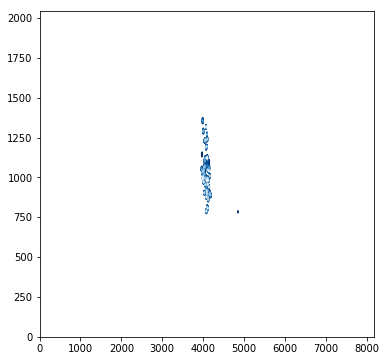

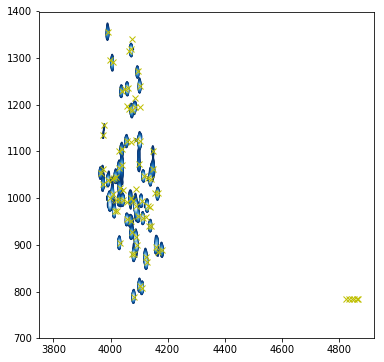

In [41]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# plot parameters
cmap = matplotlib.cm.Blues_r    # contour map (colors to use for contours)
contour_start = 30000           # contour level start value
contour_num = 20                # number of contour levels
contour_factor = 1.20           # scaling factor between contour levels
## calculate contour levels
cl = [contour_start * contour_factor ** x for x in range(contour_num)]
# Make figures
f1, ax1 = plt.subplots(1, figsize=(6, 6))
f2, ax2 = plt.subplots(1, figsize=(6, 6))

if True:
    ax1.contour(data, cl, cmap=cmap, extent=(0, data.shape[1]-1, 0, data.shape[0]-1))

    # Limit show
    x0 = 3750
    x1 = 4250
    y0 = 700
    y1 = 1400
    xpad = 0
    ypad = 0
    if x0 > x1:
        x0, x1 = x1, x0
    if y0 > y1:
        y0, y1 = y1, y0

    # slice the data around the peak
    dataslice = data[y0 - ypad:y1 + 1 + ypad, x0 - xpad:x1 + 1 + xpad]
    extent = (x0 - xpad + 1, x1 + xpad - 1, y0 - ypad + 1, y1 + ypad - 1)
    ax2.contour(dataslice, cl, cmap=cmap, extent=extent)

    # Plot points
    ptsX=peakfile['X_AXIS']
    ptsY=peakfile['Y_AXIS']
    ax2.plot(ptsX, ptsY, "x", color='y')

# Make a measurement of the peaks. 

This can be done by using seriesTab

* https://spin.niddk.nih.gov/NMRPipe/ref/prog/seriestab.html

In [44]:
! seriesTab -in test.tab -out test.ser -list ft2_files.ls -max -dx 1 -dy 1

In [45]:
# See output
! head -n 15 test.ser | nl -ba

     1	REMARK SeriesTab Input: test.tab Output: test.ser
     2	REMARK Mode: Maximum Dimensions: 2
     3	REMARK Input Region:    X +/- 1 X-ZF: 3
     4	REMARK Analysis Region: X +/- 1
     5	REMARK Input Region:    Y +/- 1 Y-ZF: 3
     6	REMARK Analysis Region: Y +/- 1
     7	
     8	VARS   INDEX X_AXIS Y_AXIS DX DY X_PPM Y_PPM X_HZ Y_HZ XW YW XW_HZ YW_HZ X1 X3 Y1 Y3 HEIGHT DHEIGHT VOL PCHI2 TYPE ASS CLUSTID MEMCNT Z_A0 Z_A1 Z_A2 Z_A3 Z_A4 Z_A5 Z_A6 Z_A7 Z_A8 Z_A9
     9	FORMAT %5d %9.3f %9.3f %6.3f %6.3f %8.3f %8.3f %9.3f %9.3f %7.3f %7.3f %8.3f %8.3f %4d %4d %4d %4d %+e %+e %+e %.5f %d %s %4d %4d %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f
    10	
    11	NULLVALUE -666
    12	NULLSTRING *
    13	
    14	    1  4826.972   784.264  0.716  4.626  141.553  133.604 17791.740  6766.790   7.113  14.102   43.416   34.429 4822 4829  779  789 -3.068895e+04 +8.669779e+02 -3.066648e+04 0.00000 1 None    1    1  1.0000  0.9673  0.7892  0.6927  0.5555  0.4019  0.4280  0.2652  0.24

# Make a script file for relax

In [48]:
# Make a script file for relax
txtout = r"""
from auto_analyses.relax_fit import Relax_fit
from pipe_control.mol_res_spin import spin_loop

# Taken from the relax disp manual, section 10.6.1 Dispersion script mode - the sample script
# Create the data pipe.
pipe_name = 'base pipe'
pipe_bundle = 'test'
pipe.create(pipe_name=pipe_name, bundle=pipe_bundle, pipe_type='relax_fit')

# Create the spins
spectrum.read_spins(file="test.ser", dir=None)

# Read the spectrum from NMRSeriesTab file. The "auto" will generate spectrum name of form: Z_A{i}
spectrum.read_intensities(file="test.ser", dir=None, spectrum_id='auto', int_method='height')

# Open the settings file.
set_file = open('ft2_files_info.txt', 'r')

for i, line in enumerate(set_file):
    # Set the current spectrum id
    current_id = "Z_A%s"%(i)
 
    # Get the relax time in seconds instead of us.
    relaxT_i = float(line.split()[1])/1e6
    rmsd_i = float(line.split()[2])
    sfrq_i = float(line.split()[3])
 
    print(relaxT_i, rmsd_i, sfrq_i)
 
    # Set time
    relax_fit.relax_time(time=relaxT_i, spectrum_id=current_id)
 
    # Set noise
    spectrum.baseplane_rmsd(error=rmsd_i, spectrum_id=current_id)
 
    # Set sfrq
    spectrometer.frequency(id=current_id, frq=sfrq_i, units='MHz')

    # Select the relaxation curve type. Also support inversion 'inv' and  saturation recovery experiment 'sat'.
    relax_fit.select_model(model='exp')

state.save("ini_state", force=True)

# Check for any negative intensities, and deselect spins
for c_s, c_s_mol, c_s_resi, c_s_resn, c_s_id in spin_loop(full_info=True, return_id=True, skip_desel=True):
    for key in c_s.peak_intensity:
        intensity = c_s.peak_intensity[key]
        if intensity <= 0.0:
            deselect.spin(c_s_id)
            print(c_s_id, key, intensity)
            break

Relax_fit(pipe_name=pipe_name, pipe_bundle=pipe_bundle, file_root='Rx', results_dir="relax_res", grid_inc=11, mc_sim_num=3, view_plots=False)

state.save("done_state", force=True)
"""

# write file
with open('relax_01.py', "w") as f:
    f.write(txtout)


# Check the file

In [49]:
! cat relax_01.py


from auto_analyses.relax_fit import Relax_fit
from pipe_control.mol_res_spin import spin_loop

# Taken from the relax disp manual, section 10.6.1 Dispersion script mode - the sample script
# Create the data pipe.
pipe_name = 'base pipe'
pipe_bundle = 'test'
pipe.create(pipe_name=pipe_name, bundle=pipe_bundle, pipe_type='relax_fit')

# Create the spins
spectrum.read_spins(file="test.ser", dir=None)

# Read the spectrum from NMRSeriesTab file. The "auto" will generate spectrum name of form: Z_A{i}
spectrum.read_intensities(file="test.ser", dir=None, spectrum_id='auto', int_method='height')

# Open the settings file.
set_file = open('ft2_files_info.txt', 'r')

for i, line in enumerate(set_file):
    # Set the current spectrum id
    current_id = "Z_A%s"%(i)
 
    # Get the relax time in seconds instead of us.
    relaxT_i = float(line.split()[1])/1e6
    rmsd_i = float(line.split()[2])
    sfrq_i = float(line.split()[3])
 
    print(relaxT_i, rmsd_i, sfrq_i)
 
    # Set time
    relax_fi

# run relax

This can be done here in the Notebook, or start a new terminal, and execute: **dre relax relax_01.py**

In [18]:
! rm -rf relax_01.log

# To noisy
#! relax relax_01.py -t relax_01.log

# Out to log
! relax relax_01.py -l relax_01.log

Opening the file 'relax_01.log' for writing.
Redirecting the sys.stdin IO stream to the Python stdin IO stream.
Redirecting the sys.stdout IO stream to the log file 'relax_01.log'.
Redirecting the sys.stderr IO stream to both the Python stderr IO stream and the log file 'relax_01.log'.
= Completion of the relaxation curve-fitting auto-analysis =

Elapsed time:  4.348 seconds


relax> state.save(state='done_state', dir=None, compress_type=1, force=True)
Opening the file 'done_state.bz2' for writing.



In [19]:
# See the log
! tail -n 10 relax_01.log

= Completion of the relaxation curve-fitting auto-analysis =

Elapsed time:  4.348 seconds


relax> state.save(state='done_state', dir=None, compress_type=1, force=True)
Opening the file 'done_state.bz2' for writing.



# Make xmgrace images
relax make a grace2images script to make PNG images.

In [20]:
%%bash
# Make images
cd relax_res/grace
python grace2images.py PNG

Converting 'chi2.agr' into a portable network graphics (PNG) graphic.
Converting 'i0.agr' into a portable network graphics (PNG) graphic.
Converting 'intensities.agr' into a portable network graphics (PNG) graphic.
Converting 'intensities_norm.agr' into a portable network graphics (PNG) graphic.
Converting 'None_10_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_11_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_12_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_13_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_14_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_15_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_16_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_17_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_18_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_19_A.agr' i

Output is truncated - tune device dimensions
Output is truncated - tune device dimensions


relax_res/grace/intensities.png
![intensities](./relax_res/grace/intensities.png)

relax_res/grace/Rx.png
![Rx](./relax_res/grace/Rx.png)

# Make more graphs

In [15]:
# Make a script file for relax
txtout = r"""
from pipe_control.mol_res_spin import spin_loop
state.load("done_state", force=True)

outdir = "relax_res/grace"

# Loop over spins
for c_s, c_s_mol, c_s_resi, c_s_resn, c_s_id in spin_loop(full_info=True, return_id=True, skip_desel=True):
    fname = "%s_%s_%s.agr"%(c_s_mol, c_s_resi, c_s_resn)
    grace.write(x_data_type='relax_times', y_data_type='peak_intensity', spin_id=c_s_id, plot_data='value', file=fname, dir=outdir, force=True, norm=False)
"""

# write file
with open('relax_02.py', "w") as f:
    f.write(txtout)

In [16]:
! cat relax_02.py


from pipe_control.mol_res_spin import spin_loop
state.load("done_state", force=True)

outdir = "relax_res/grace"

# Loop over spins
for c_s, c_s_mol, c_s_resi, c_s_resn, c_s_id in spin_loop(full_info=True, return_id=True, skip_desel=True):
    fname = "%s_%s_%s.agr"%(c_s_mol, c_s_resi, c_s_resn)
    grace.write(x_data_type='relax_times', y_data_type='peak_intensity', spin_id=c_s_id, plot_data='value', file=fname, dir=outdir, force=True, norm=False)


In [17]:
! rm -rf relax_02.log
! relax relax_02.py -l relax_02.log
! tail -n 10 relax_02.log

Opening the file 'relax_02.log' for writing.
Redirecting the sys.stdin IO stream to the Python stdin IO stream.
Redirecting the sys.stdout IO stream to the log file 'relax_02.log'.
Redirecting the sys.stderr IO stream to both the Python stderr IO stream and the log file 'relax_02.log'.

relax> grace.write(x_data_type='relax_times', y_data_type='peak_intensity', spin_id=':93@N', plot_data='value', norm_type='first', file='None_93_A.agr', dir='relax_res/grace', force=True, norm=False)
Opening the file 'relax_res/grace/None_93_A.agr' for writing.

relax> grace.write(x_data_type='relax_times', y_data_type='peak_intensity', spin_id=':95@N', plot_data='value', norm_type='first', file='None_95_A.agr', dir='relax_res/grace', force=True, norm=False)
Opening the file 'relax_res/grace/None_95_A.agr' for writing.

relax> grace.write(x_data_type='relax_times', y_data_type='peak_intensity', spin_id=':96@N', plot_data='value', norm_type='first', file='None_96_A.agr', dir='relax_res/grace', force=True

In [21]:
%%bash
# Make images
cd relax_res/grace
python grace2images.py PNG

Converting 'chi2.agr' into a portable network graphics (PNG) graphic.
Converting 'i0.agr' into a portable network graphics (PNG) graphic.
Converting 'intensities.agr' into a portable network graphics (PNG) graphic.
Converting 'intensities_norm.agr' into a portable network graphics (PNG) graphic.
Converting 'None_10_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_11_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_12_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_13_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_14_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_15_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_16_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_17_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_18_A.agr' into a portable network graphics (PNG) graphic.
Converting 'None_19_A.agr' i

Output is truncated - tune device dimensions
Output is truncated - tune device dimensions


relax_res/grace/None_8_A.png
![intensities](./relax_res/grace/None_8_A.png)